In [ ]:
!git clone https://github.com/Senyu-T/unifiedqa

In [ ]:
cd unifiedqa/bart

In [ ]:
!chmod +x download_data.sh; ./download_data.sh

In [ ]:
cd data/natural_questions_with_dpr_para/

In [16]:
# read dev file, parse into context / question / answer for further data analysis
infer_answers = []
infer_questions = []
infer_contexts = []
with open('dev.tsv', 'rb') as inference_in:
    lines = inference_in.readlines()
    for i in range(len(lines)):
        sep = str(lines[i]).split('\\n') 
        infer_questions.append(sep[0][2:-1])
        infer_answers.append((sep[1].split('\\t')[-1]).lower())
        infer_contexts.append(sep[1].split('\\t')[0])

In [17]:
# check how many short answers are not extracted from the context
not_in_dpr_idx = []
for i in range(len(infer_answers)):
  if not infer_answers[i] in infer_contexts[i]:
    not_in_dpr_idx.append(i)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/out/finetune_bart_base_2_epoch/

In [8]:
# read the prediction file output by model
import json
with open("predictions.json", 'rb') as m_out:
    pred = json.load(m_out)

In [ ]:
print(len(infer_answers), len(pred))

10693 10693


In [49]:
# detokenize: restore special marks
# also find special token (forien language)
cnt_special_char = 0
foreign_chars = set()
for i in range(len(infer_answers)):
  infer_answers[i] = infer_answers[i].replace(' \\\'\\\'', ' \'\'')   # double quotation
  infer_answers[i] = infer_answers[i].replace('\\\'', '\'')
  infer_answers[i] = infer_answers[i].replace(' \'s', '\'s')    # 's
  infer_answers[i] = infer_answers[i].replace(' ,', ',')        # comma
  if '\\' in infer_answers[i]:
    cnt_special_char += 1
    foreign_chars.add(i)
    #print(f"{i}  {infer_answers[i]}      {pred[i]}")
print(cnt_special_char)

120


In [47]:
example_foreign = 0
for i in range(len(infer_answers)):
  if "\\" in infer_answers[i]:
    print(f"{i}: {infer_answers[i]:20s}    {pred[i]}")
    example_foreign += 1
    if example_foreign >= 5:
      break

36: ch\xc3\xa2teau d'amboise    the palace of fontainebleau
38: ch\xc3\xa2teau de chambord    the palace of fontainebleau
104: milo\xc5\xa1 forman     milos forman
260: alexander nor\xc3\xa9n    cameron menzies
324: the journal des d\xc3\xa9bats    petion


In [50]:
# Gold-answer not a substring of context
ctx_cnt = 0
for i in not_in_dpr_idx:
  if infer_answers[i] != pred[i]:
    #print(f"{i}: {infer_answers[i]:20s}{pred[i]}")
    ctx_cnt += 1
print(ctx_cnt)

3292


In [39]:
# further normalize the answers
import string
import re
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

print(normalize_answer(infer_answers[36]))

chxc3xa2teau damboise


In [ ]:
!pip install python-Levenshtein

In [55]:
from collections import defaultdict
from Levenshtein import distance

question_len_all = defaultdict(int)
question_len_wrong = defaultdict(int)
word_freq_all = defaultdict(lambda: 0)
word_freq_wrong = defaultdict(lambda: 0)
start_freq_all = defaultdict(lambda: 0)
start_freq_wrong = defaultdict(lambda: 0)

total_edit_distance = 0.0
cnt_wrong = 0
for i in range(len(infer_answers)):
  Q = infer_questions[i]
  tokens = Q.split(' ')
  start = tokens[0]
  start_freq_all[start] += 1
  question_len_all[len(tokens)] += 1
  for token in tokens:
    word_freq_all[token] += 1
  # error:
  if infer_answers[i] != pred[i]:
    # we omit foreign tokens
    if i in foreign_chars: continue
    dis = distance(infer_answers[i], pred[i])
    start_freq_wrong[start] += 1
    question_len_wrong[len(tokens)] += 1
    total_edit_distance += dis
    cnt_wrong += 1
    #for a in A:
      #word_freq_wrong[a] += 1
print(cnt_wrong, total_edit_distance/cnt_wrong)

7467 11.507298781304407


In [64]:
question_start_dict = dict(sorted(start_freq_all.items(), key=lambda item: item[1], reverse=True))

In [127]:
q_start_all = list(question_start_dict.items())[:7]
print(q_start_all)

[('who', 4474), ('when', 1877), ('what', 1378), ('where', 889), ('how', 492), ('the', 234), ('which', 186)]


In [68]:
question_start_err_dict = dict(sorted(start_freq_wrong.items(), key=lambda item: item[1], reverse=True))

In [128]:
q_start_err = list(question_start_err_dict.items())[:7]
print(q_start_err)

[('who', 2868), ('when', 1213), ('what', 1106), ('where', 698), ('how', 346), ('the', 184), ('which', 136)]


In [131]:
plt_start = 1 - np.array(list(map(lambda x: float(x[1][1]) / float(x[0][1]), zip(q_start_all, q_start_err))))
print(plt_start)
x = np.arange(len(plt_start))
keys = list(map(lambda x:x[0], q_start_all))
print(keys)

[0.3589629  0.35375599 0.19738752 0.21484814 0.29674797 0.21367521
 0.2688172 ]
['who', 'when', 'what', 'where', 'how', 'the', 'which']


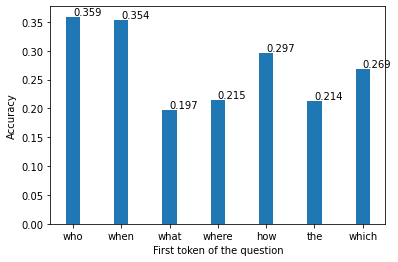

In [140]:
import numpy as np
import matplotlib.pyplot as plt

plt.bar(x, plt_start,width=0.3)
for a, b in zip(x, plt_start):
  plt.text(a, b + 0.0025, f"{b:.3f}")
plt.xticks(x, keys)
plt.xlabel("First token of the question")
plt.ylabel("Accuracy")
plt.show()

In [141]:
plt.close()

In [85]:
print(question_len_all)
print(question_len_wrong)
len_dict = {}
for k,v in question_len_all.items():
  len_dict[k] = float(question_len_wrong[k]) / v
len_dict = dict(sorted(len_dict.items(), key=lambda item: item[0]))
print(len_dict)

defaultdict(<class 'int'>, {8: 5009, 9: 2600, 10: 1313, 11: 625, 7: 372, 13: 189, 12: 324, 17: 17, 15: 66, 14: 112, 16: 40, 6: 17, 18: 6, 19: 1, 22: 1, 20: 1})
defaultdict(<class 'int'>, {8: 3558, 9: 1774, 10: 901, 11: 445, 13: 142, 12: 217, 7: 237, 15: 52, 14: 82, 16: 24, 6: 14, 18: 5, 19: 1, 17: 13, 22: 1, 20: 1, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})
{6: 0.8235294117647058, 7: 0.6370967741935484, 8: 0.7103214214414054, 9: 0.6823076923076923, 10: 0.6862147753236862, 11: 0.712, 12: 0.6697530864197531, 13: 0.7513227513227513, 14: 0.7321428571428571, 15: 0.7878787878787878, 16: 0.6, 17: 0.7647058823529411, 18: 0.8333333333333334, 19: 1.0, 20: 1.0, 22: 1.0}


In [101]:
plt_len = np.array(list(range(7,14)))
plt_len_all = list(dict(sorted(question_len_all.items(), key=lambda item: item[0])).items())[1:len(plt_len) + 1]
plt_len_err = list(dict(sorted(question_len_wrong.items(), key=lambda item: item[0])).items())[7:len(plt_len) + 7]
print(plt_len_all)
print(plt_len_err)

[(7, 372), (8, 5009), (9, 2600), (10, 1313), (11, 625), (12, 324), (13, 189)]
[(7, 237), (8, 3558), (9, 1774), (10, 901), (11, 445), (12, 217), (13, 142)]


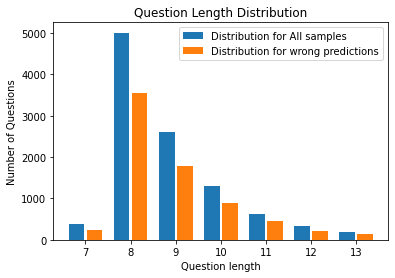

In [106]:
plt_len_all = np.array(list(map(lambda x: x[1], plt_len_all)))
plt_len_err = np.array(list(map(lambda x: x[1], plt_len_err)))

width = 0.35
x = np.arange(7)
plt.bar(x-0.2, plt_len_all, width)
plt.bar(x+0.2, plt_len_err, width)

plt.xticks(x, plt_len)
plt.xlabel("Question length")
plt.ylabel("Number of Questions")
plt.legend(["Distribution for All samples", "Distribution for wrong predictions"])
plt.title('Question Length Distribution')
plt.show()


In [ ]:
plt.close()